<a href="https://colab.research.google.com/github/balladembelemoussa/codesandbox-template-nuxt/blob/main/%C3%89tiquette_d'angle_invariant_%C3%A0_l'%C3%A9chelle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Étiquette d'angle invariant à l'échelle 
Cet exemple montre comment créer une annotation d'angle invariant à l'échelle. Il est souvent utile de marquer les angles entre les lignes ou à l'intérieur des formes avec un arc de cercle. Alors que Matplotlib fournit unArc , un problème inhérent lors de son utilisation directe à de telles fins est qu'un arc circulaire dans l'espace de données n'est pas nécessairement circulaire dans l'espace d'affichage. De plus, le rayon de l'arc est souvent mieux défini dans un système de coordonnées indépendant des coordonnées réelles des données - du moins si vous souhaitez pouvoir zoomer librement sur votre tracé sans que l'annotation ne s'étende à l'infini.

Cela appelle une solution où le centre de l'arc est défini dans l'espace de données, mais son rayon dans une unité physique comme des points ou des pixels, ou comme un rapport de la dimension Axes. Ce qui suitAngleAnnotation classe suivante fournit une telle solution.

L'exemple ci-dessous a deux objectifs :

Il fournit une solution prête à l'emploi pour le problème de dessiner facilement des angles dans des graphiques.

Il montre comment sous-classer un artiste Matplotlib pour améliorer ses fonctionnalités, ainsi que donner un exemple pratique sur la façon d'utiliser le système de transformation de Matplotlib .

Si vous êtes principalement intéressé par le premier, vous pouvez copier la classe ci-dessous et passer à la section Utilisation .

Classe AngleAnnotation 
L'idée essentielle ici est de sous-classer Arcet de définir sa transformation sur IdentityTransform, en définissant les paramètres de l'arc dans l'espace pixel. Nous remplaçons ensuite les Arcattributs _center, theta1, theta2et widthet heighten faisons des propriétés, couplées à des méthodes internes qui calculent les paramètres respectifs à chaque accès à l'attribut et garantissent ainsi que l'arc dans l'espace pixel reste synchronisé avec les points d'entrée et la taille. Par exemple, chaque fois que la méthode de dessin de l'arc interrogeait son fichier_center attribut, au lieu de recevoir à nouveau le même nombre, elle recevra à la place le résultat de la get_center_in_pixelsméthode que nous avons définie dans la sous-classe. Cette méthode transforme le centre des coordonnées de données en pixels via la transformation Axesax.transData. La taille et les angles sont calculés de la même manière, de sorte que l'arc change automatiquement de forme lors, par exemple, d'un zoom ou d'un panoramique interactif.

La fonctionnalité de cette classe permet d'annoter l'arc avec un texte. Ce texte est Annotationstocké dans un attribut text. Étant donné que la position et le rayon de l'arc ne sont définis qu'au moment du dessin, nous devons mettre à jour la position du texte en conséquence. Cela se fait en réimplémentant la Arcméthode draw()de pour lui permettre d'appeler une méthode de mise à jour pour le texte.

L'arc et le texte seront ajoutés aux Axes fournis lors de l'instanciation : il n'est donc pas strictement nécessaire d'en garder une référence.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.transforms import IdentityTransform, TransformedBbox, Bbox


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.from_bounds(0, 0, 1, 1),
                                self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])


# Utilisation 
Les arguments requis pour AngleAnnotationsont le centre de l'arc, xy et deux points, de sorte que l'arc s'étende entre les deux vecteurs reliant p1 et p2 à xy , respectivement. Ceux-ci sont donnés en coordonnées de données. D'autres arguments sont la taille de l'arc et son unité . De plus, un texte peut être spécifié, qui sera dessiné à l'intérieur ou à l'extérieur de l'arc, selon la valeur de textposition . L'utilisation de ces arguments est illustrée ci-dessous.

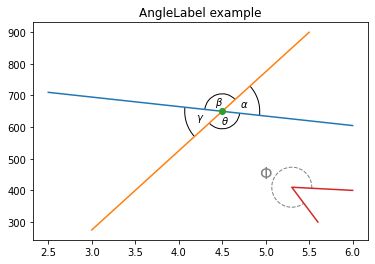

In [6]:
fig, ax = plt.subplots()
fig.canvas.draw()  # Need to draw the figure to define renderer
ax.set_title("AngleLabel example")

# Plot two crossing lines and label each angle between them with the above
# ``AngleAnnotation`` tool.
center = (4.5, 650)
p1 = [(2.5, 710), (6.0, 605)]
p2 = [(3.0, 275), (5.5, 900)]
line1, = ax.plot(*zip(*p1))
line2, = ax.plot(*zip(*p2))
point, = ax.plot(*center, marker="o")

am1 = AngleAnnotation(center, p1[1], p2[1], ax=ax, size=75, text=r"$\alpha$")
am2 = AngleAnnotation(center, p2[1], p1[0], ax=ax, size=35, text=r"$\beta$")
am3 = AngleAnnotation(center, p1[0], p2[0], ax=ax, size=75, text=r"$\gamma$")
am4 = AngleAnnotation(center, p2[0], p1[1], ax=ax, size=35, text=r"$\theta$")


# Showcase some styling options for the angle arc, as well as the text.
p = [(6.0, 400), (5.3, 410), (5.6, 300)]
ax.plot(*zip(*p))
am5 = AngleAnnotation(p[1], p[0], p[2], ax=ax, size=40, text=r"$\Phi$",
                      linestyle="--", color="gray", textposition="outside",
                      text_kw=dict(fontsize=16, color="gray"))

# AngleLabeloption 
Les arguments textposition et unit mot-clé peuvent être utilisés pour modifier l'emplacement de l'étiquette de texte, comme indiqué ci-dessous :

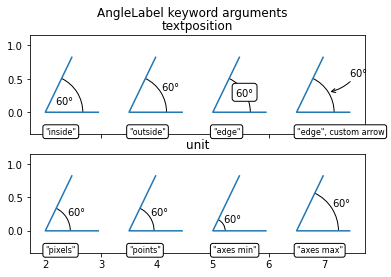

In [7]:
# Helper function to draw angle easily.
def plot_angle(ax, pos, angle, length=0.95, acol="C0", **kwargs):
    vec2 = np.array([np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))])
    xy = np.c_[[length, 0], [0, 0], vec2*length].T + np.array(pos)
    ax.plot(*xy.T, color=acol)
    return AngleAnnotation(pos, xy[0], xy[2], ax=ax, **kwargs)


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.suptitle("AngleLabel keyword arguments")
fig.canvas.draw()  # Need to draw the figure to define renderer

# Showcase different text positions.
ax1.margins(y=0.4)
ax1.set_title("textposition")
kw = dict(size=75, unit="points", text=r"$60°$")

am6 = plot_angle(ax1, (2.0, 0), 60, textposition="inside", **kw)
am7 = plot_angle(ax1, (3.5, 0), 60, textposition="outside", **kw)
am8 = plot_angle(ax1, (5.0, 0), 60, textposition="edge",
                 text_kw=dict(bbox=dict(boxstyle="round", fc="w")), **kw)
am9 = plot_angle(ax1, (6.5, 0), 60, textposition="edge",
                 text_kw=dict(xytext=(30, 20), arrowprops=dict(arrowstyle="->",
                              connectionstyle="arc3,rad=-0.2")), **kw)

for x, text in zip([2.0, 3.5, 5.0, 6.5], ['"inside"', '"outside"', '"edge"',
                                          '"edge", custom arrow']):
    ax1.annotate(text, xy=(x, 0), xycoords=ax1.get_xaxis_transform(),
                 bbox=dict(boxstyle="round", fc="w"), ha="left", fontsize=8,
                 annotation_clip=True)

# Showcase different size units. The effect of this can best be observed
# by interactively changing the figure size
ax2.margins(y=0.4)
ax2.set_title("unit")
kw = dict(text=r"$60°$", textposition="outside")

am10 = plot_angle(ax2, (2.0, 0), 60, size=50, unit="pixels", **kw)
am11 = plot_angle(ax2, (3.5, 0), 60, size=50, unit="points", **kw)
am12 = plot_angle(ax2, (5.0, 0), 60, size=0.25, unit="axes min", **kw)
am13 = plot_angle(ax2, (6.5, 0), 60, size=0.25, unit="axes max", **kw)

for x, text in zip([2.0, 3.5, 5.0, 6.5], ['"pixels"', '"points"',
                                          '"axes min"', '"axes max"']):
    ax2.annotate(text, xy=(x, 0), xycoords=ax2.get_xaxis_transform(),
                 bbox=dict(boxstyle="round", fc="w"), ha="left", fontsize=8,
                 annotation_clip=True)

plt.show()